# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
num_input_layers = 3

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import os
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples.
n_valid = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(list(set(y_train)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

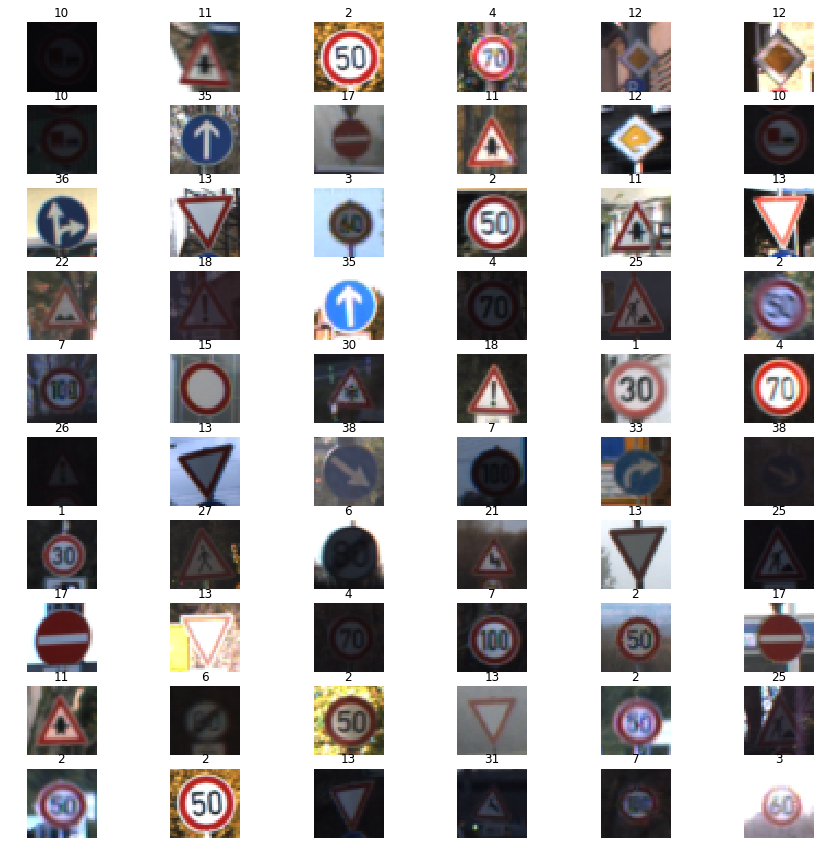

In [4]:
import random
import numpy as np
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


# Simply, display some of the training images with their true labels
num_images = 60
count = 1
fig = plt.figure(figsize=(15, 15))
for a in range(1, num_images+1):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    a = fig.add_subplot(num_images/6,6,count)
    plt.imshow(image)
    plt.axis('off')
    a.set_title(y_train[index])
    count += 1


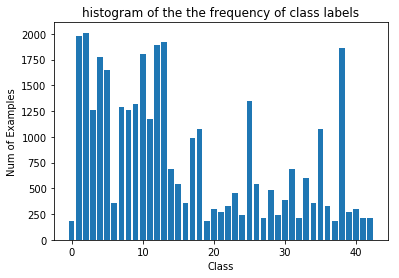

In [5]:
# Display histogram of class labels    
def plot_class_histogram(labels_):
    values, counts = np.unique(labels_, return_counts=True)
    plt.figure()
    plt.bar(values, counts)
    plt.ylabel('Num of Examples')
    plt.xlabel('Class')
    plt.title('histogram of the the frequency of class labels')
    return values, counts

values, counts = plot_class_histogram(y_train)

In [6]:
# Ref: https://github.com/vxy10/ImageAugmentation

import matplotlib.gridspec as gridspec
import cv2

def augment_brightness_camera_images(image):
    image = image.astype(np.float32)
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(image, ang_range, shear_range, trans_range, brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    img = image.copy()
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img


In [7]:
from tqdm import tqdm

# As we saw that some classes have as few as ~200 samples, while few others have as many as ~2000 samples.
# Lets add synthetic data into TRAINING dataset to have a more BALANCED datset 
print("Before adding synthetic data:")        
print (X_train.shape, y_train.shape)  

# Reload the data
pickle_file = 'synthetic_data.pickle'
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        X_train = pickle_data['X_train']
        y_train = pickle_data['y_train']
        del pickle_data  # Free up memory

    print('Data and modules loaded.')
else:    
    MAX_TRAIN_IMAGE_COUNT = 1000
    for label, count in zip(values,counts):
        print (label, count)
        if count<MAX_TRAIN_IMAGE_COUNT:
            # find number of images to be generated for this "label"
            get_extra_img_count = MAX_TRAIN_IMAGE_COUNT-count

            # find images with the same "label" in training set
            X_train_label = X_train[np.where(y_train==label)]

            for c in range(get_extra_img_count):
                # randomly choose a training image with the same "label"
                img = random.choice(X_train_label)
                # transform the image
                img_new = transform_image(img, 20, 10, 5, brightness=1)

                # reshape the transformed image and its "label"
                img_new = img_new.reshape([1, 32, 32, 3])
                label = label.reshape([1])

                X_train = np.concatenate([X_train, img_new])
                y_train = np.concatenate([y_train, label])                    

print("After adding synthetic data:")        
print (X_train.shape, y_train.shape)            


Before adding synthetic data:
(34799, 32, 32, 3) (34799,)
Data and modules loaded.
After adding synthetic data:
(51690, 32, 32, 3) (51690,)


In [8]:
# Save the data for easy access
import os

pickle_file = 'synthetic_data.pickle'
if not os.path.exists(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('synthetic_data.pickle', 'wb') as pfile:
            pickle.dump({'X_train': X_train, 'y_train': y_train,}, pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


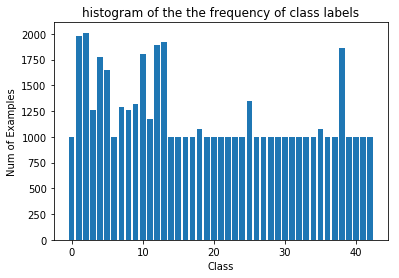

In [9]:
# Lets analyzed the training dataset after adding synthetic images
values, counts = plot_class_histogram(y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
# Shuffle the dataset
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
print (X_train.shape)

(51690, 32, 32, 3)


In [11]:
'''
    I considered the following options for preprocessing:
    
    (1) Gaussian blur
    (2) RGB to gray conversion
    (3) Normalization scheme 1: (RGB-128)/128
    (4) Normalization scheme 2
    
    Out of these 4, I experimentally found that (2) and (3) improve the classification 
    accuracy on validation and testing dataset. While, (1) and (4) decrease the performance.
    Thereore, I decided to use only (2) and (3) in my pipeline.
'''

'\n    I considered the following options for preprocessing:\n    \n    (1) Gaussian blur\n    (2) RGB to gray conversion\n    (3) Normalization scheme 1: (RGB-128)/128\n    (4) Normalization scheme 2\n    \n    Out of these 4, I experimentally found that (2) and (3) improve the classification \n    accuracy on validation and testing dataset. While, (1) and (4) decrease the performance.\n    Thereore, I decided to use only (2) and (3) in my pipeline.\n'

In [12]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import cv2

### Intensity equalization #########################################
def equalize(image):    
    img = np.copy(image)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
    if len(img.shape) > 2:
        dims = 3
        for i in range(dims):
            img[:,:,i] = clahe.apply(img[:,:,i])
    else:
        img = clahe.apply(img)
    return img

### Gaussian Blur #########################################
def blur(image):
    return cv2.GaussianBlur(image,(3,3),0)

### Grayscale the images #########################################
def grayscale(img_):
    # plt.imshow(gray, cmap='gray')
#     img_ = img_.astype(np.float32)
    img = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)
    return np.reshape(img, (img.shape[0], img.shape[1], 1))

### Data Normalization ###########################################
def normalize_1(img_):
    #change type to np.float32 to accomodate negative numbers
#     normalized = (img_.astype(np.float32) - 128)/128  
    normalized = (img_ - 128)/128
    return normalized

def normalize_2(img_):
    # Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    out_min = 0.1
    out_max = 0.9
    greyscale_min = 0
    greyscale_max = 255
    
    slope = (out_max - out_min)/( greyscale_max - greyscale_min )
    return slope*(img_.astype(np.float32) - greyscale_min) + out_min


In [13]:
#  Preprocess images here
import time
import numpy as np


def preprocess(image):
    image = image.astype(np.uint8)    
    if num_input_layers==3:
        img_ret = normalize_2(image)
    else:
        img_ret = normalize_2(grayscale(image))
    return img_ret

def preprocess_batch(images):
    imgs = []
    for i in tqdm(range(images.shape[0])):
        imgs.append(preprocess(images[i]))
    return np.array(imgs)

X_train = preprocess_batch(X_train)
X_valid = preprocess_batch(X_valid)
X_test = preprocess_batch(X_test)
# print (X_train.shape)

100%|██████████| 12630/12630 [00:00<00:00, 68543.60it/s]


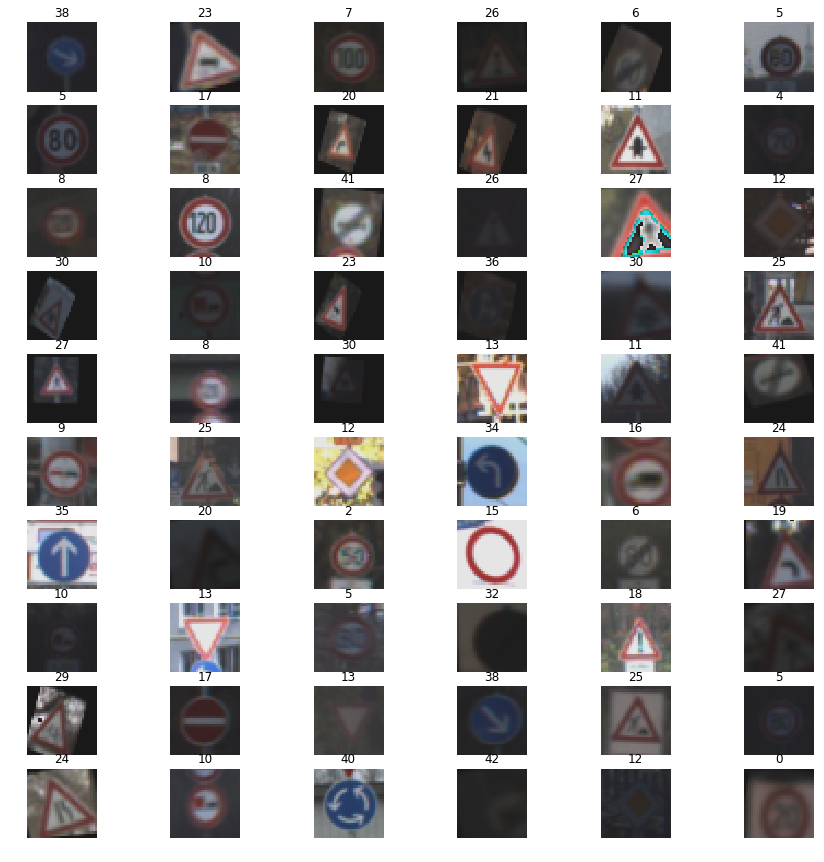

In [14]:
# Simply, display some of the training images with their true labels
num_images = 60
count = 1
fig = plt.figure(figsize=(15, 15))
for a in range(1, num_images+1):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    a = fig.add_subplot(num_images/6,6,count)
    plt.imshow(image)
    plt.axis('off')
    a.set_title(y_train[index])
    count += 1

### Model Architecture

In [15]:
'''
    I used the standard LeNet architecture as my base. Furthermore, I attempted the following 
    changes into the architecture:
    
    (1) Local Response Normalization
    (2) Dropout
    (3) L2 regularization
    
    All of these 3 seems to be improving the performance on validation and test set. 
    In fact Local-response-normalization is most effective of all. 
    It improved the performance by almost 2%.
'''

'\n    I used the standard LeNet architecture as my base. Furthermore, I attempted the following \n    changes into the architecture:\n    \n    (1) Local Response Normalization\n    (2) Dropout\n    (3) L2 regularization\n    \n    All of these 3 seems to be improving the performance on validation and test set. \n    In fact Local-response-normalization is most effective of all. \n    It improved the performance by almost 2%.\n'

In [16]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten


EPOCHS = 20
BATCH_SIZE = 128

# place holder for dropout keep probability
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)


def LeNetModified(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # HINT:
    # The shape of the filter weight is (height, width, input_depth, output_depth)
#     conv0_W = tf.Variable(tf.truncated_normal(shape=(1, 1, num_input_layers, num_input_layers), mean=mu, stddev=sigma))
#     conv0_b = tf.Variable(tf.zeros(num_input_layers))
#     conv0 = tf.nn.conv2d(x, conv0_W, strides=[1, 1, 1, 1], padding='VALID') + conv0_b
#     # TODO: Activation.
#     conv0 = tf.nn.relu(conv0)
    
#     # Response normalization following convolutional activations
#     conv0 = tf.nn.local_response_normalization(conv0)
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, num_input_layers, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Response normalization following convolutional activations
    conv1 = tf.nn.local_response_normalization(conv1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # Response normalization following convolutional activations
    conv2 = tf.nn.local_response_normalization(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b

    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    # Store layers weight & bias to be used by L2 regularization
    weights = { 'conv1': conv1_W, 'conv2': conv2_W, 'fc1': fc1_W, 'fc2': fc2_W, 'fc3': fc3_W }
    biases =  { 'conv1': conv1_b, 'conv2': conv2_b, 'fc1': fc1_b, 'fc2': fc2_b, 'fc3': fc3_b }

    return logits, weights, biases, conv1

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
'''
    I did not try changing the learning rate, since 0.001 seems to be really fine to me. 
    0.0001 is going to be pretty slow convergence, while 0.01 is too high in my opinion.
'''

'\n    I did not try changing the learning rate, since 0.001 seems to be really fine to me. \n    0.0001 is going to be pretty slow convergence, while 0.01 is too high in my opinion.\n'

In [18]:
# x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.
x = tf.placeholder(tf.float32, (None, 32, 32, num_input_layers))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

rate = 0.001

#logits = LeNet(x)
logits, weights, biases, conv1 = LeNetModified(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)


In [19]:
########## Add L2 regularization for weights and biases terms ##########
regularizers = tf.nn.l2_loss(weights['conv1']) + tf.nn.l2_loss(biases['conv1']) + \
               tf.nn.l2_loss(weights['conv2']) + tf.nn.l2_loss(biases['conv2']) + \
               tf.nn.l2_loss(weights['fc1']) + tf.nn.l2_loss(biases['fc1']) + \
               tf.nn.l2_loss(weights['fc2']) + tf.nn.l2_loss(biases['fc2']) + \
            tf.nn.l2_loss(weights['fc3']) + tf.nn.l2_loss(biases['fc3']) 
                
# Add the regularization term to the loss.
beta = 5e-4  #0.0001
loss_operation += beta * regularizers

In [20]:
'''
    I did not change the Adam-Optimizer since it is pretty fast and I 
    was training on CPUs only. So, faster optimization seemed like a good choice.
    Although, I am sure other Gradient Decent schemes might improve a little.
'''

'\n    I did not change the Adam-Optimizer since it is pretty fast and I \n    was training on CPUs only. So, faster optimization seemed like a good choice.\n    Although, I am sure other Gradient Decent schemes might improve a little.\n'

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

top_k = tf.placeholder(tf.int32, (None))
label_prediction = tf.argmax(tf.nn.softmax(logits), 1)
# label_prediction = tf.argmax(logits, 1)
top_k_label_prediction = tf.nn.top_k(tf.nn.softmax(logits), k=top_k)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [22]:
# Evaluate how well the loss and accuracy of the model for a given dataset.
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]        
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training...

EPOCH 1 ...
Training Accuracy = 0.623
Validation Accuracy = 0.705

EPOCH 2 ...
Training Accuracy = 0.642
Validation Accuracy = 0.818

EPOCH 3 ...
Training Accuracy = 0.811
Validation Accuracy = 0.862

EPOCH 4 ...
Training Accuracy = 0.840
Validation Accuracy = 0.907

EPOCH 5 ...
Training Accuracy = 0.896
Validation Accuracy = 0.922

EPOCH 6 ...
Training Accuracy = 0.877
Validation Accuracy = 0.931

EPOCH 7 ...
Training Accuracy = 0.887
Validation Accuracy = 0.930

EPOCH 8 ...
Training Accuracy = 0.849
Validation Accuracy = 0.940

EPOCH 9 ...
Training Accuracy = 0.915
Validation Accuracy = 0.941

EPOCH 10 ...
Training Accuracy = 0.906
Validation Accuracy = 0.947

EPOCH 11 ...
Training Accuracy = 0.906
Validation Accuracy = 0.941

EPOCH 12 ...
Training Accuracy = 0.896
Validation Accuracy = 0.946

EPOCH 13 ...
Training Accuracy = 0.953
Validation Accuracy = 0.948

EPOCH 14 ...
Training Accuracy = 0.943
Validation Accuracy = 0.949

EPOCH 15 ...
Training Accuracy = 0.953
Valid

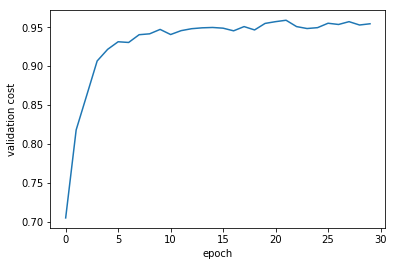

In [23]:
# Training
# Launch the graph
sess_config = tf.ConfigProto()

train_costs = []
valid_costs = []
with tf.Session(config= sess_config) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(30):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end] 
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.75})
        
        # compute accuracy for the current training batch
        training_accuracy = evaluate(batch_x, batch_y)
        train_costs.append(training_accuracy)
        
        # compute accuracy for the entire validation set
        validation_accuracy = evaluate(X_valid, y_valid)        
        valid_costs.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    save_path = saver.save(sess, "./lenet_traffic")
    print("Model saved in file: %s" % save_path)

    # plot
    plt.plot(valid_costs)
    plt.ylabel('validation cost')
    plt.xlabel('epoch')
    plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [24]:
with tf.Session() as sess:
    saver.restore(sess, "./lenet_traffic")

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.940


### Load and Output the Images

In [25]:
'''
    Manually downloaded 5  German traffic sign images from google. They are displayed below.
'''

'\n    Manually downloaded 5  German traffic sign images from google. They are displayed below.\n'

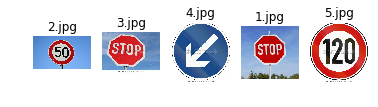

In [26]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os, sys
import fnmatch
import skimage.io      

def display_images(images):
    count = 1
    fig = plt.figure()
    for path in images:
        image = images[path]
        a = fig.add_subplot(1,len(images),count)
        if image.shape[2]==1:
            plt.imshow(np.reshape(image, (image.shape[0], image.shape[1])))
        else:
            plt.imshow(image)                
        plt.axis('off')
        a.set_title(os.path.basename(path))
        count += 1
    return  

images_ext = {}
inputDir = "./images"
if os.path.isdir(inputDir):
    for root, dirnames, filenames in os.walk(inputDir):
        for filename in fnmatch.filter(filenames, '*.jpg'):
            im = os.path.join(root, filename)
            image = skimage.io.imread(im)            
            images_ext[im] = image
            
display_images(images_ext)            


### Predict the Sign Type for Each Image

./images/2.jpg [1]
./images/2.jpg TopKV2(values=array([[ 0.94672465,  0.04030244,  0.00902292,  0.00113126,  0.00102505]], dtype=float32), indices=array([[ 1,  0,  2, 31,  4]], dtype=int32))
./images/3.jpg [14]
./images/3.jpg TopKV2(values=array([[  9.90556300e-01,   3.48476670e-03,   2.89494940e-03,
          2.16443324e-03,   4.71495616e-04]], dtype=float32), indices=array([[14, 17,  0,  9, 10]], dtype=int32))
./images/4.jpg [39]
./images/4.jpg TopKV2(values=array([[  9.98491168e-01,   1.31815462e-03,   1.37785188e-04,
          4.25545695e-05,   9.46409091e-06]], dtype=float32), indices=array([[39, 33, 37, 40,  6]], dtype=int32))
./images/5.jpg [0]
./images/5.jpg TopKV2(values=array([[ 0.84185314,  0.03713676,  0.0243352 ,  0.01725472,  0.01607974]], dtype=float32), indices=array([[ 0,  1, 31, 16, 21]], dtype=int32))
./images/1.jpg [14]
./images/1.jpg TopKV2(values=array([[ 0.41140309,  0.36877862,  0.20926622,  0.00894089,  0.00135778]], dtype=float32), indices=array([[14, 17, 12, 

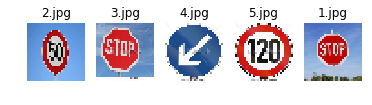

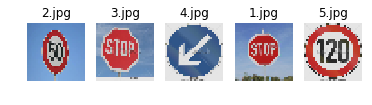

In [27]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
import skimage.transform

# resize images to 32x32x3
images_ext_resized = {}
for path in images_ext:
    image = images_ext[path]
    image = skimage.transform.resize(image, [32,32,3])    
    images_ext_resized[path] = image

display_images(images_ext_resized)

images_ext_processed = dict()
with tf.Session() as sess:
    saver.restore(sess, "./lenet_traffic")
    for path in images_ext_resized:
        image = images_ext_resized[path]
        image = 255 * image
        X = preprocess(image)
        images_ext_processed[path] = X
        X = np.array([X])# (1,32,32,num_input_layers))
        
        # top-1 result  
        p1 = sess.run(label_prediction, feed_dict={x: X, keep_prob:1.0}) 
        print (path,p1)
        
        # top-5 results
        p2 = sess.run(top_k_label_prediction, feed_dict={x: X, top_k:5, keep_prob:1.0}) 
        print (path,p2) 

display_images(images_ext_processed)

### Analyze Performance

In [28]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

'''
    1.jpg -> Actual label = 14, Detected label = 31
    2.jpg -> Actual label =  2, Detected label = 19
    3.jpg -> Actual label = 14, Detected label = 19
    4.jpg -> Actual label = 39, Detected label = 19
    5.jpg -> Actual label =  8, Detected label = 31
    
    => Top 1 accuracy = 0%
'''

'\n    1.jpg -> Actual label = 14, Detected label = 31\n    2.jpg -> Actual label =  2, Detected label = 19\n    3.jpg -> Actual label = 14, Detected label = 19\n    4.jpg -> Actual label = 39, Detected label = 19\n    5.jpg -> Actual label =  8, Detected label = 31\n    \n    => Top 1 accuracy = 0%\n'

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [29]:
'''
    Test Image    |     Certainty Level    |     True Sign in Top 5 Probabilities
    1.jpg                     18.7%                             NO                                    
    2.jpg                     16.1%                             NO
    3.jpg                     18.0%                             NO
    4.jpg                     17.4%                             NO
    5.jpg                     16.4%                             NO
    
    => Top 5 accuracy = 0%
'''



'\n    Test Image    |     Certainty Level    |     True Sign in Top 5 Probabilities\n    1.jpg                     18.7%                             NO                                    \n    2.jpg                     16.1%                             NO\n    3.jpg                     18.0%                             NO\n    4.jpg                     17.4%                             NO\n    5.jpg                     16.4%                             NO\n    \n    => Top 5 accuracy = 0%\n'

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [30]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents 
#                the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default 
#                     matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just 
#          extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, "./lenet_traffic")
        activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

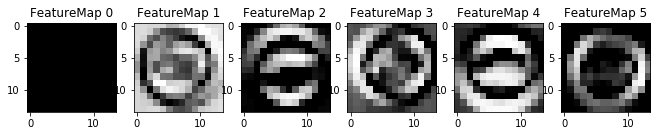

In [31]:
outputFeatureMap(X_test, conv1)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

In [32]:
# Close the session. This will destroy the trained model.
# session.close()